In [2]:
import os
import sys
import pickle
from tqdm.notebook import tqdm as tqdm
import random

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sys.path.append("../")

from batch_generators import DataGenerator
from models import BinaryRankingModel, WeibullModel
from tools import test_quality 

In [4]:
s = 1

random.seed(s)
np.random.seed(s)
tf.set_random_seed(s)
os.environ['PYTHONHASHSEED'] = str(s)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

##### Load METABRIC data

In [3]:
with open('../data/metabric.pkl', 'rb') as f:
    [
        (x_train, y_train),
        (x_test, y_test),
        (x_val, y_val)
    ] = pickle.load(f)

In [4]:
t_train = y_train[:, 0]
y_train = y_train[:, 1]

t_test = y_test[:, 0]
y_test = y_test[:, 1]

t_val = y_val[:, 0]
y_val = y_val[:, 1]

Set common parameters for learning

In [5]:
n_time_bins = 10
metabric_val_size = 30228
n_epochs = 3
time_grid = np.linspace(0, 300, 30, dtype=np.int)
inp_shape = (None, x_train.shape[1])

##### 1. Standard learning weibull parameters 

In [6]:
graph_path = '../logs/graphs'
model_path = '../model/weibull_model'
batch_size = 1024

model = WeibullModel(input_shape=inp_shape)
optimizer = tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.9, beta2=0.99)
# optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
train = optimizer.minimize(model.loss)
saver = tf.train.Saver()

# validation data
dg = DataGenerator(x=x_val, y=y_val, t=t_val, batch_size=metabric_val_size, n_time_bins=n_time_bins)
[x_batch_left_val, x_batch_right_val], y_batch_val, sample_weight_val, target_val = next(dg.get_batch())

dg = DataGenerator(x=x_train, y=y_train, t=t_train, batch_size=batch_size, n_time_bins=n_time_bins)
n_batches = min(dg.ij_pos_sorted.shape[1], dg.ij_neg_sorted.shape[1]) // batch_size

loss_summary = tf.summary.scalar(name='train_loss', tensor=model.loss) 
val_loss_summary = tf.summary.scalar(name='val_loss', tensor=model.loss)
hist_losses_train = []
all_pred = []
# Launch the graph
with tf.device('/GPU:0'):
    with tf.Session() as sess:
        tf.set_random_seed(s)
        init = tf.initialize_all_variables()
        sess.run(init)
        writer = tf.summary.FileWriter(graph_path, sess.graph)
        # for each epoch
        for i in tqdm(range(n_epochs)):
            # initialize generator
            gen = dg.get_batch()
            # for each batch
            for j in range(n_batches):
                # get batch data
                [x_batch_left, x_batch_right], y_batch, sample_weight, target = next(gen)
                feed_dict = {
                    model.x_a: x_batch_left, 
                    model.x_b: x_batch_right, 
                    model.t_a: y_batch[:, 0].reshape((batch_size, 1)),
                    model.t_b: y_batch[:, 1].reshape((batch_size, 1)),
                    model.y_a: y_batch[:, 2].reshape((batch_size, 1)),
                    model.y_b: y_batch[:, 3].reshape((batch_size, 1)),
                    model.target: target.reshape((batch_size, 1)),
                    model.sample_weight: sample_weight
                }
                # train model
                _, l = sess.run([train, model.loss], feed_dict=feed_dict)
            # check train and val loss at the end of epoch    
            loss_train = sess.run(loss_summary, feed_dict=feed_dict)
            loss_val = sess.run(val_loss_summary, feed_dict={
                    model.x_a: x_batch_left_val, 
                    model.x_b: x_batch_right_val, 
                    model.t_a: y_batch_val[:, 0].reshape((metabric_val_size, 1)),
                    model.t_b: y_batch_val[:, 1].reshape((metabric_val_size, 1)),
                    model.y_a: y_batch_val[:, 2].reshape((metabric_val_size, 1)),
                    model.y_b: y_batch_val[:, 3].reshape((metabric_val_size, 1)),
                    model.target: target_val.reshape((metabric_val_size, 1)),
                    model.sample_weight: sample_weight_val
                })
            # write summary
            writer.add_summary(loss_train, i)
            writer.add_summary(loss_val, i)
            # get predictions for validation data
            pred = sess.run(model.o1, feed_dict={model.x_a: x_val})
#             print(np.mean(pred, axis=0))
            all_pred.append(pred)
            hist_losses_train.append(l)
            # save model
            saver.save(sess, model_path)





Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [7]:
last_epoch_pred = all_pred[-1]

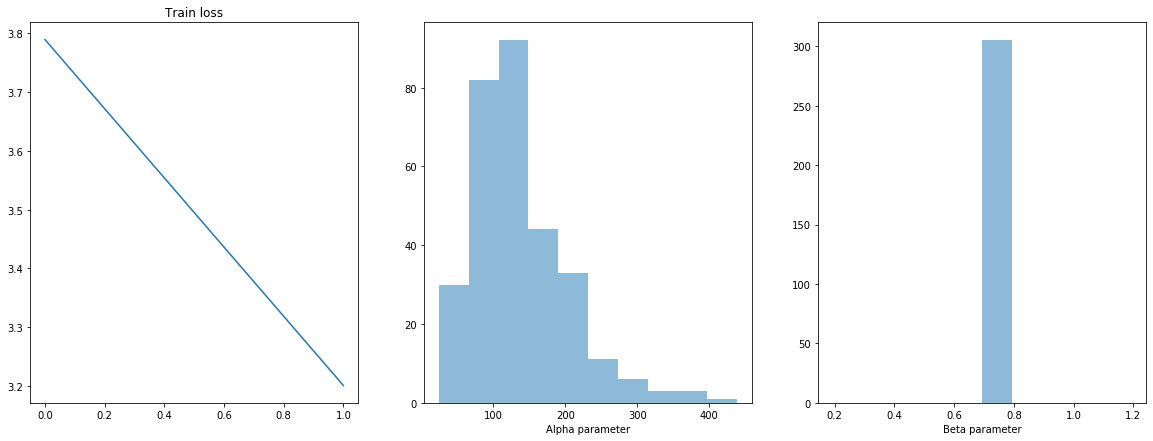

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(20, 7))

ax[0].plot(hist_losses_train[1:])
ax[0].set_title('Train loss')

ax[1].hist(last_epoch_pred[:, 0], alpha=0.5)
ax[1].set_xlabel('Alpha parameter')

ax[2].hist(last_epoch_pred[:, 1], alpha=0.5)
ax[2].set_xlabel('Beta parameter');

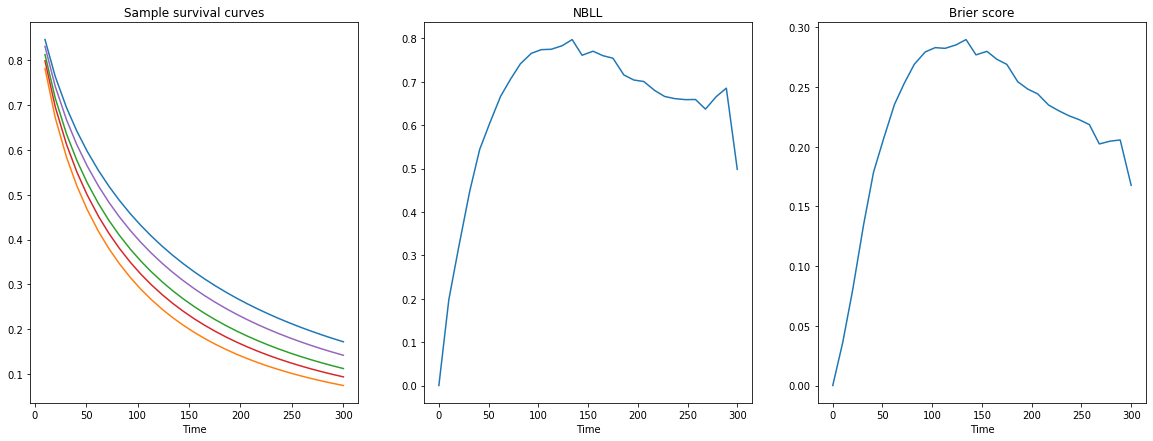

In [9]:
q_weibull = test_quality(t_true=t_val, y_true=y_val, pred=last_epoch_pred, 
             time_grid=time_grid, concordance_at_t=103)

In [10]:
q_weibull

,harell_c_index,dt_c_index,int_brier_score,int_nbill
0,0.619008,0.604056,0.22408,0.651573


##### 2. Pairwise ranking learning weibull parameters 

In [6]:
graph_path = '../logs/graphs'
model_path = '../model/binary_weibull_model'
batch_size = 1024

model = BinaryRankingModel(input_shape=inp_shape)
optimizer = tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.9, beta2=0.99)
# optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
train = optimizer.minimize(model.loss)
saver = tf.train.Saver()

# validation data
dg = DataGenerator(x=x_val, y=y_val, t=t_val, batch_size=metabric_val_size, n_time_bins=n_time_bins)
[x_batch_left_val, x_batch_right_val], y_batch_val, sample_weight_val, target_val = next(dg.get_batch())

dg = DataGenerator(x=x_train, y=y_train, t=t_train, batch_size=batch_size, n_time_bins=n_time_bins)
n_batches = min(dg.ij_pos_sorted.shape[1], dg.ij_neg_sorted.shape[1]) // batch_size

loss_summary = tf.summary.scalar(name='train_loss', tensor=model.loss) 
val_loss_summary = tf.summary.scalar(name='val_loss', tensor=model.loss)
hist_losses_train = []
all_pred = []
# Launch the graph
with tf.device('/GPU:0'):
    with tf.Session() as sess:
        tf.set_random_seed(s)
        init = tf.initialize_all_variables()
        sess.run(init)
        writer = tf.summary.FileWriter(graph_path, sess.graph)
        # for each epoch
        for i in tqdm(range(n_epochs)):
            # initialize generator
            gen = dg.get_batch()
            # for each batch
            for j in range(n_batches):
                # get batch data
                [x_batch_left, x_batch_right], y_batch, sample_weight, target = next(gen)
                feed_dict = {
                    model.x_a: x_batch_left, 
                    model.x_b: x_batch_right, 
                    model.t_a: y_batch[:, 0].reshape((batch_size, 1)),
                    model.t_b: y_batch[:, 1].reshape((batch_size, 1)),
                    model.y_a: y_batch[:, 2].reshape((batch_size, 1)),
                    model.y_b: y_batch[:, 3].reshape((batch_size, 1)),
                    model.target: target.reshape((batch_size, 1)),
                    model.sample_weight: sample_weight
                }
                # train model
                _, l = sess.run([train, model.loss], feed_dict=feed_dict)
            # check train and val loss at the end of epoch    
            loss_train = sess.run(loss_summary, feed_dict=feed_dict)
            loss_val = sess.run(val_loss_summary, feed_dict={
                    model.x_a: x_batch_left_val, 
                    model.x_b: x_batch_right_val, 
                    model.t_a: y_batch_val[:, 0].reshape((metabric_val_size, 1)),
                    model.t_b: y_batch_val[:, 1].reshape((metabric_val_size, 1)),
                    model.y_a: y_batch_val[:, 2].reshape((metabric_val_size, 1)),
                    model.y_b: y_batch_val[:, 3].reshape((metabric_val_size, 1)),
                    model.target: target_val.reshape((metabric_val_size, 1)),
                    model.sample_weight: sample_weight_val
                })
            # write summary
            writer.add_summary(loss_train, i)
            writer.add_summary(loss_val, i)
            # get predictions for validation data
            pred = sess.run(model.o1, feed_dict={model.x_a: x_val})
#             print(np.mean(pred, axis=0))
            all_pred.append(pred)
            hist_losses_train.append(l)
            # save model
            saver.save(sess, model_path)




Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [7]:
last_epoch_pred = all_pred[-1]

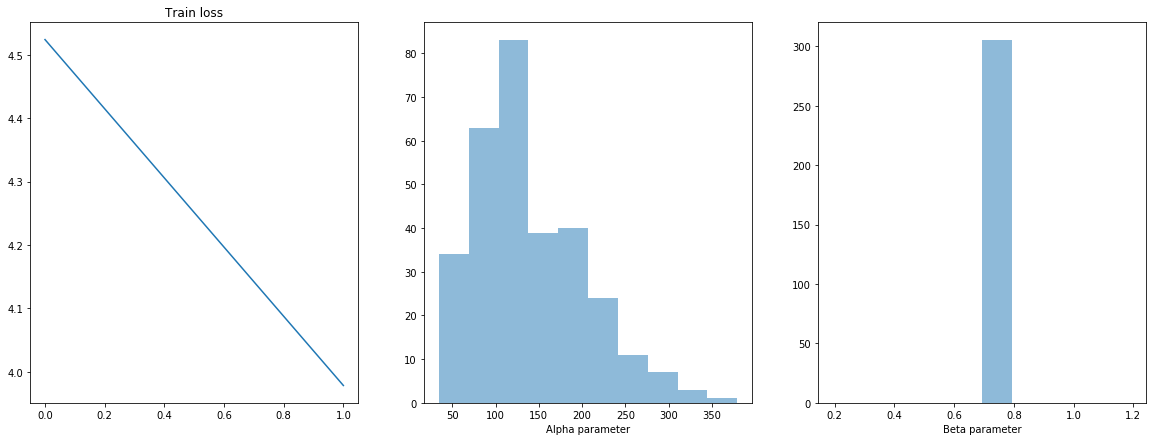

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(20, 7))

ax[0].plot(hist_losses_train[1:])
ax[0].set_title('Train loss')

ax[1].hist(last_epoch_pred[:, 0], alpha=0.5)
ax[1].set_xlabel('Alpha parameter')

ax[2].hist(last_epoch_pred[:, 1], alpha=0.5)
ax[2].set_xlabel('Beta parameter');

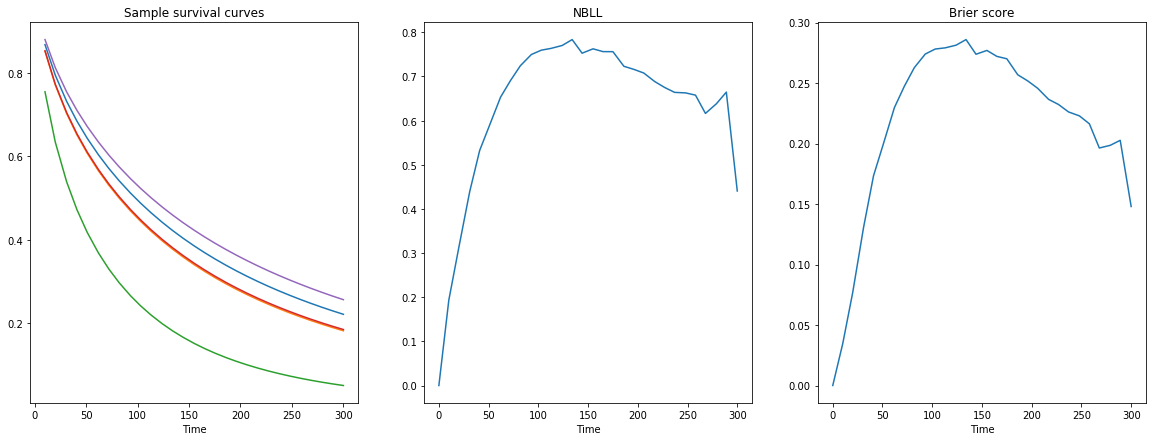

In [10]:
q_weibull_binary = test_quality(t_true=t_val, y_true=y_val, pred=last_epoch_pred, 
             time_grid=time_grid, concordance_at_t=103)

In [11]:
q_weibull_binary

,harell_c_index,dt_c_index,int_brier_score,int_nbill
0,0.62837,0.613418,0.221256,0.643795


In [ ]:
# TODO: check loss - which is better (with/without weighting)
# TODO: bigger variance to beta - separate tensors for alpha and beta